##***DeepFake Detection Using Deep Learning***




## **Setup and Library Imports**

In [1]:
import os
import torch
from torch import nn
import random
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
seed=40303
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
import os
os.chdir('../')

In [4]:
os.getcwd()

'h:\\project'

## **Helper Functions**

In [5]:
from src.utils import *

## **Data Reading, Splitting and Loading**

In [6]:
from src.dataset import *

In [7]:
train_df, valid_df, _, _ = load_data()

In [8]:
_, man_index = get_split(train_df, size=0.05)
train_man = train_df.loc[man_index, :]
train_man.reset_index(drop=True, inplace=True)
train_man.label.value_counts()

FAKE    187
REAL    185
Name: label, dtype: int64

In [9]:
_, man_index = get_split(valid_df, size=0.25)
valid_man = valid_df.loc[man_index, :]
valid_man.reset_index(drop=True, inplace=True)
valid_man.label.value_counts()

FAKE    216
REAL    120
Name: label, dtype: int64

In [10]:
train_man.head()

,filename,label,path,origin,frames,inv_frame
0,xjzmkuxskq.mp4,REAL,h:\project\dfdc\dfdc_part_1_1\xjzmkuxskq,dfdc,1,0
1,id42_id48_0002.mp4,FAKE,h:\project\CelebDF-v2\faces\id42_id48_0002,CelebDF-v2,1,0
2,jkonwkrhqp.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\jkonwkrhqp,dfdc,3,1
3,Sally_Kirkland_2,REAL,./youtube_faces_dataset/faces\Sally_Kirkland_2,ytf,1,0
4,vejylrlysf.mp4,FAKE,h:\project\dfdc\dfdc_part_2_1\vejylrlysf,dfdc,1,0


## **Run manual hyperparameter search **

In [11]:
from src.models.deepfake_detectors import Efficientnet
from src.train_val_funcs import train_epoch, run_inference


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


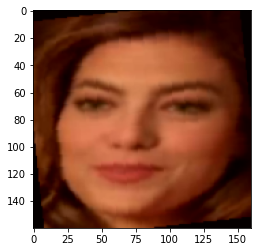

In [12]:
#preprocess the data
train_data = VideoDataset(train_man, 50, transform = train_transforms(160))
val_data = VideoDataset(valid_man, 50, transform = test_transforms(160))

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)
#plot the data
image,label = train_data[1]
im_plot(image[1,:,:,:])

In [1]:
!pip install ipywidgets==7.7.1

     -------------------------------------- 123.4/123.4 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.2
    Uninstalling ipywidgets-7.7.2:
      Successfully uninstalled ipywidgets-7.7.2
Note: you may need to restart the kernel to use updated packages.


In [13]:

def train_function(learning_rate=0.001, dropout_rate=0.3, image_size=112, frames_to_use=50, weight_decay=1e-5):
    #learning rate
    lr = learning_rate
    
    #preprocess the data
    train_data = VideoDataset(train_man, frames_to_use, image_size, transform = train_transforms(image_size) )
    val_data = VideoDataset(valid_man, frames_to_use, image_size, transform = test_transforms(image_size) )

    #load the data into dataloaders
    train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
    valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)
    
    #instantiate the model
    model1 = Efficientnet(2, dropout_rate).cuda()
    #number of epochs 
    num_epochs = 5

    optimizer = torch.optim.Adam(model1.parameters(), lr= lr, weight_decay = weight_decay)

    criterion = nn.CrossEntropyLoss().cuda()
    train_loss_avg =[]
    train_accuracy = []
    val_loss_avg = []
    val_accuracy = []
    best_accuracy = 0
    for epoch in range(1,num_epochs+1):
        l, acc = train_epoch(epoch,train_loader,model1,criterion,optimizer)
        train_loss_avg.append(l)
        train_accuracy.append(acc)
        #validation step
        true,pred,tl,t_acc = run_inference(model1,valid_loader,criterion)
        val_loss_avg.append(tl)
        val_accuracy.append(t_acc)
        if t_acc > best_accuracy:
            best_accuracy = t_acc
            #torch.save(model1.state_dict(),'./effnet_{}.pt'.format(epoch))
    return tl
    

In [16]:
import math 

hyperparam={'learning_rate':[1e-5, 1e-4, 1e-3], 'dropout_rate': [0.2, 0.3, 0.4], 'image_size': [100, 112, 130], 
                             'frames_to_use': [10,30,50] }

best_score = [math.inf]*4
best_params = [0,0,0,0]

already_tested = set()

for i,key in enumerate(hyperparam):
    params = [1e-5, 0.2, 100, 10]
    for v in hyperparam[key]:
        params[i] = v
        if tuple(params) in already_tested:
            continue
        already_tested.add(tuple(params))
        print('testing ', params)
        
        loss_val = train_function(*params)
        if loss_val < best_score[i]:
            
            best_params[i] = v
            best_score[i] = loss_val
            print(best_params)

testing  [1e-05, 0.2, 100, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

[1e-05, 0, 0, 0]
testing  [0.0001, 0.2, 100, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

[0.0001, 0, 0, 0]
testing  [0.001, 0.2, 100, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

testing  [1e-05, 0.3, 100, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

[0.0001, 0.3, 0, 0]
testing  [1e-05, 0.4, 100, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

testing  [1e-05, 0.2, 112, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

[0.0001, 0.3, 112, 0]
testing  [1e-05, 0.2, 130, 10]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

testing  [1e-05, 0.2, 100, 30]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

[0.0001, 0.3, 112, 30]
testing  [1e-05, 0.2, 100, 50]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

In [19]:
best_params

[0.0001, 0.3, 112, 30]

In [20]:
already_tested

{(1e-05, 0.2, 100, 10),
 (1e-05, 0.2, 100, 30),
 (1e-05, 0.2, 100, 50),
 (1e-05, 0.2, 112, 10),
 (1e-05, 0.2, 130, 10),
 (1e-05, 0.3, 100, 10),
 (1e-05, 0.4, 100, 10),
 (0.0001, 0.2, 100, 10),
 (0.001, 0.2, 100, 10)}

: 